In [1]:
import keras
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import time
import sys
import os
%matplotlib inline  

Using TensorFlow backend.


In [2]:
all_fixtures = pd.read_csv('all_fixtures.csv')
all_players_groupby = pd.read_csv('all_players_groupby.csv')

In [3]:
all_players_groupby.head()

,name,team,season,count,id
0,Adrien Silva,leicester-city,2018,9,1
1,AdriÃ¡n,west-ham-united,2016,32,2
2,AdriÃ¡n,west-ham-united,2017,16,2
3,AdriÃ¡n,west-ham-united,2018,19,2
4,Alberto Moreno,liverpool-fc,2016,28,3


## all_fixtures stats

In [4]:
np.mean(all_fixtures.home_score),np.mean(all_fixtures.away_score)

(1.5403508771929824, 1.1859649122807017)

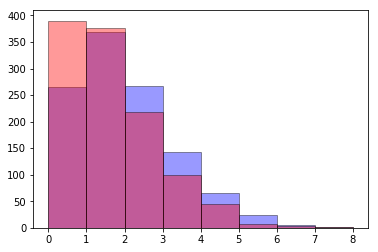

In [5]:
ax = plt.subplot()
_ = ax.hist(all_fixtures.home_score,alpha=0.4, color="blue",bins=(range(9)), edgecolor="black")
_ = ax.hist(all_fixtures.away_score,alpha=0.4, color="red",bins=(range(9)),  edgecolor="black")

## all_players_groupby stats

In [6]:
train_seasons = [2016,2017]
test_seasons = [2018]

In [7]:
all_players_groupby_train = all_players_groupby[all_players_groupby['season'].isin(train_seasons)]
all_players_groupby_test = all_players_groupby[all_players_groupby['season'].isin(test_seasons)]

In [8]:
name_columns = ['name','count']
all_players_groupby_train_names = all_players_groupby_train[name_columns].groupby('name').sum().reset_index()
all_players_groupby_train_names.head()

,name,count
0,AdriÃ¡n,48
1,Alberto Moreno,30
2,Aleix GarcÃ­a,1
3,Alexandre Pato,1
4,Ander Herrera,44


In [9]:
test_names = all_players_groupby_test[name_columns].groupby('name').sum().reset_index()
test_names.head()

,name,count
0,Adrien Silva,9
1,AdriÃ¡n,19
2,Alberto Moreno,14
3,Ander Herrera,13
4,Ayoze PÃ©rez,28


In [10]:
new_players = np.setdiff1d(test_names['name'],all_players_groupby_train_names['name'])
len(new_players)

130

In [11]:
recurring_players = np.intersect1d(test_names['name'],all_players_groupby_train_names['name'])
len(recurring_players)

348

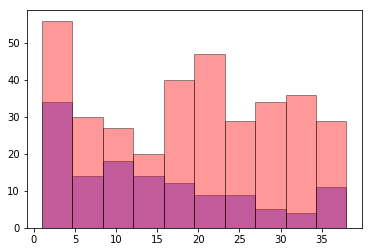

In [12]:
ax = plt.subplot()
_ = ax.hist(test_names[test_names["name"].isin(new_players)]["count"],alpha=0.4, color="blue", edgecolor="black")
_ = ax.hist(test_names[test_names["name"].isin(recurring_players)]["count"],alpha=0.4, color="red", edgecolor="black")

In [13]:
np.mean(test_names[test_names["name"].isin(new_players)]["count"]),np.mean(test_names[test_names["name"].isin(recurring_players)]["count"])

(14.361538461538462, 18.658045977011493)

In [14]:
np.sum(test_names[test_names["name"].isin(new_players)]["count"]),np.sum(test_names[test_names["name"].isin(recurring_players)]["count"])

(1867, 6493)

In [15]:
(6493 + 1867)/1867.

4.477771826459561

In [16]:
np.mean(all_players_groupby_train_names["count"])

25.96273291925466

In [17]:
test_names_recurring = test_names[test_names["name"].isin(recurring_players)].merge(all_players_groupby_train_names,on="name")

In [18]:
test_names_recurring.head()

,name,count_x,count_y
0,AdriÃ¡n,19,48
1,Alberto Moreno,14,30
2,Ander Herrera,13,44
3,Ayoze PÃ©rez,28,22
4,Azpilicueta,37,74


In [19]:
len(test_names_recurring)

348

In [20]:
np.mean(test_names_recurring["count_y"])

35.66954022988506

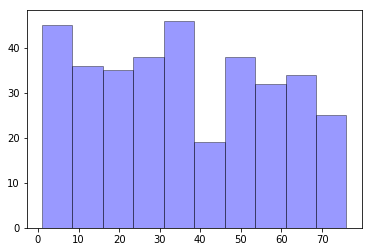

In [21]:
ax = plt.subplot()
_ = ax.hist(test_names_recurring["count_y"],alpha=0.4, color="blue", edgecolor="black")

## Changing all_fixtures names to ids

In [22]:
names = all_players_groupby.groupby(["name","id"]).sum().reset_index()
names.head()

,name,id,season,count
0,Adrien Silva,1,2018,9
1,AdriÃ¡n,2,6051,67
2,Alberto Moreno,3,6051,44
3,Aleix GarcÃ­a,4,2017,1
4,Alexandre Pato,5,2016,1


In [23]:
number_players = 11
names_ids_dict = pd.Series(names.id.values,index=names.name).to_dict()
all_fixtures_copy = all_fixtures.copy()
players_columns = []
for which_team in ['home', 'away']:
    for i in range(1,number_players+1):
        players_columns.append(which_team +(str(i)))
for players_column in players_columns:
    all_fixtures_copy[players_column] = all_fixtures_copy[players_column].map(names_ids_dict)

In [24]:
all_fixtures_copy

,home_team,away_team,home1,home2,home3,home4,home5,home6,home7,home8,...,away5,away6,away7,away8,away9,away10,away11,home_score,away_score,season
0,afc-bournemouth,arsenal-fc,146,681,691,196,97,230,133,506,...,35,550,86,535,594,116,122,0.0,2.0,2016
1,afc-bournemouth,aston-villa,146,681,691,728,196,230,133,506,...,418,344,666,149,424,302,419,0.0,1.0,2016
2,afc-bournemouth,chelsea-fc,146,681,691,728,196,230,133,506,...,16,401,583,78,272,67,24,1.0,4.0,2016
3,afc-bournemouth,crystal-palace,146,681,691,196,97,230,133,334,...,229,365,426,395,380,299,755,0.0,0.0,2016
4,afc-bournemouth,everton-fc,93,681,691,196,705,230,133,334,...,181,366,304,643,144,641,33,3.0,3.0,2016
5,afc-bournemouth,leicester-city,146,681,691,728,196,133,539,289,...,387,234,138,505,573,633,374,1.0,1.0,2016
6,afc-bournemouth,liverpool-fc,146,681,691,728,196,230,133,439,...,53,392,455,677,73,232,425,1.0,2.0,2016
7,afc-bournemouth,manchester-city,146,681,691,196,97,133,539,289,...,585,29,40,450,22,28,466,0.0,4.0,2016
8,afc-bournemouth,manchester-united,146,681,691,196,97,230,133,334,...,187,59,552,519,391,549,141,2.0,1.0,2016
9,afc-bournemouth,newcastle-united,93,681,196,97,705,230,133,334,...,244,316,571,744,8,198,113,0.0,1.0,2016


In [25]:
all_fixtures

,home_team,away_team,home1,home2,home3,home4,home5,home6,home7,home8,...,away5,away6,away7,away8,away9,away10,away11,home_score,away_score,season
0,afc-bournemouth,arsenal-fc,Artur Boruc,Simon Francis,Steve Cook,Charlie Daniels,Adam Smith,Dan Gosling,Andrew Surman,Marc Pugh,...,HÃ©ctor BellerÃ­n,Mesut Ãzil,Aaron Ramsey,Mathieu Flamini,Olivier Giroud,Alex Oxlade-Chamberlain,Alexis SÃ¡nchez,0.0,2.0,2016
1,afc-bournemouth,aston-villa,Artur Boruc,Simon Francis,Steve Cook,Tommy Elphick,Charlie Daniels,Dan Gosling,Andrew Surman,Marc Pugh,...,Jordan Amavi,Idrissa Gueye,Scott Sinclair,Ashley Westwood,Jordan Veretout,Gabriel Agbonlahor,Jordan Ayew,0.0,1.0,2016
2,afc-bournemouth,chelsea-fc,Artur Boruc,Simon Francis,Steve Cook,Tommy Elphick,Charlie Daniels,Dan Gosling,Andrew Surman,Marc Pugh,...,Cesc FÃ bregas,John Mikel,Nemanja MatiÄ,Willian,Eden Hazard,Pedro,Diego Costa,1.0,4.0,2016
3,afc-bournemouth,crystal-palace,Artur Boruc,Simon Francis,Steve Cook,Charlie Daniels,Adam Smith,Dan Gosling,Andrew Surman,Harry Arter,...,Damien Delaney,James McArthur,Jordon Mutch,Joe Ledley,Jason Puncheon,Fraizer Campbell,Wilfried Zaha,0.0,0.0,2016
4,afc-bournemouth,everton-fc,Adam Federici,Simon Francis,Steve Cook,Charlie Daniels,Sylvain Distin,Dan Gosling,Andrew Surman,Harry Arter,...,Brendan Galloway,James McCarthy,Gareth Barry,Ross Barkley,Arouna KonÃ©,Romelu Lukaku,Gerard Deulofeu,3.0,3.0,2016
5,afc-bournemouth,leicester-city,Artur Boruc,Simon Francis,Steve Cook,Tommy Elphick,Charlie Daniels,Andrew Surman,Matt Ritchie,Eunan O'Kane,...,Jeffrey Schlupp,Danny Drinkwater,Andy King,Marc Albrighton,N'Golo KantÃ©,Riyad Mahrez,Jamie Vardy,1.0,1.0,2016
6,afc-bournemouth,liverpool-fc,Artur Boruc,Simon Francis,Steve Cook,Tommy Elphick,Charlie Daniels,Dan Gosling,Andrew Surman,Junior Stanislas,...,Lucas Leiva,Joe Allen,Kevin Stewart,Sheyi Ojo,Roberto Firmino,Daniel Sturridge,Jordon Ibe,1.0,2.0,2016
7,afc-bournemouth,manchester-city,Artur Boruc,Simon Francis,Steve Cook,Charlie Daniels,Adam Smith,Andrew Surman,Matt Ritchie,Eunan O'Kane,...,NicolÃ¡s Otamendi,Fernando,JesÃºs Navas,Kevin De Bruyne,David Silva,Fernandinho,Kun AgÃ¼ero,0.0,4.0,2016
8,afc-bournemouth,manchester-united,Artur Boruc,Simon Francis,Steve Cook,Charlie Daniels,Adam Smith,Dan Gosling,Andrew Surman,Harry Arter,...,Cameron Borthwick-Jackson,Mata,Michael Carrick,Marouane Fellaini,Jesse Lingard,Memphis Depay,Anthony Martial,2.0,1.0,2016
9,afc-bournemouth,newcastle-united,Adam Federici,Simon Francis,Charlie Daniels,Adam Smith,Sylvain Distin,Dan Gosling,Andrew Surman,Harry Arter,...,Daryl Janmaat,Georginio Wijnaldum,Moussa Sissoko,Vurnon Anita,Ayoze PÃ©rez,Cheick TiotÃ©,Aleksandar MitroviÄ,0.0,1.0,2016


In [91]:
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.layers.core import Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

In [27]:
number_of_players = len(names)
starting_lineups = number_players * 2

In [68]:
train_valid_ratio=0.2
train_data = all_fixtures_copy[all_fixtures_copy.season.isin(train_seasons)]
valid_index = np.random.choice(train_data.index, int(len(train_data)*train_valid_ratio), replace=False)
valid = train_data[train_data.index.isin(valid_index)][players_columns]
valid_label = train_data[train_data.index.isin(valid_index)][['home_score','away_score']]
trn = train_data[~train_data.index.isin(valid_index)][players_columns]
trn_label = train_data[~train_data.index.isin(valid_index)][['home_score','away_score']]
test = all_fixtures_copy[all_fixtures_copy.season.isin(test_seasons)][players_columns]
test_label = all_fixtures_copy[all_fixtures_copy.season.isin(test_seasons)][['home_score','away_score']]

In [119]:
def get_callbacks(filepath, patience=2):
    es = EarlyStopping('val_loss', patience=patience, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [es, msave]

In [166]:
model = Sequential([
    Embedding(number_of_players+1, 50, input_length=starting_lineups),
    Flatten(),
    Dense(80, activation='relu'),
    Dropout(0.3),
    Dense(2)])

In [167]:
model.compile(loss='mse', optimizer=Adam())
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_22 (Embedding)     (None, 22, 50)            38750     
_________________________________________________________________
flatten_22 (Flatten)         (None, 1100)              0         
_________________________________________________________________
dense_44 (Dense)             (None, 80)                88080     
_________________________________________________________________
dropout_22 (Dropout)         (None, 80)                0         
_________________________________________________________________
dense_45 (Dense)             (None, 2)                 162       
Total params: 126,992
Trainable params: 126,992
Non-trainable params: 0
_________________________________________________________________


In [168]:
file_path = ".model_weights_temp.hdf5"
callbacks = get_callbacks(filepath=file_path, patience=7)
model.fit(trn, trn_label, validation_data=(valid, valid_label), nb_epoch=20, batch_size=16, callbacks=callbacks)

Train on 608 samples, validate on 152 samples
Epoch 1/20
608/608 [==============================] - 1s 2ms/step - loss: 2.7464 - val_loss: 1.6858
Epoch 2/20
608/608 [==============================] - 0s 207us/step - loss: 1.4500 - val_loss: 1.5138
Epoch 3/20
608/608 [==============================] - 0s 186us/step - loss: 1.1414 - val_loss: 1.4303
Epoch 4/20
608/608 [==============================] - 0s 184us/step - loss: 0.9062 - val_loss: 1.4871
Epoch 5/20
608/608 [==============================] - 0s 190us/step - loss: 0.7273 - val_loss: 1.5511
Epoch 6/20
608/608 [==============================] - 0s 186us/step - loss: 0.5345 - val_loss: 1.6003
Epoch 7/20
608/608 [==============================] - 0s 196us/step - loss: 0.4175 - val_loss: 1.6347
Epoch 8/20
608/608 [==============================] - 0s 168us/step - loss: 0.3491 - val_loss: 1.6901
Epoch 9/20
608/608 [==============================] - 0s 191us/step - loss: 0.2809 - val_loss: 1.7610
Epoch 10/20
608/608 [=================

In [169]:
model.load_weights(filepath=file_path)

print("Train evaluate:")
print(model.evaluate(trn, trn_label, verbose=1))
print("####################")
print("watch list evaluate:")
print(model.evaluate(valid, valid_label, verbose=1))

Train evaluate:
608/608 [==============================] - 0s 43us/step
0.865060589815441
####################
watch list evaluate:
152/152 [==============================] - 0s 59us/step
1.4303112343737954
